# Deep k-Nearest Neighbors (DkNN) - SVHN: Eval on Testset (SVHN)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# BUG FIX, see: https://github.com/pytorch/vision/issues/1938
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

# Load libs
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torchvision
from torchvision import transforms
import matplotlib
import matplotlib.pyplot as plt
import pickle
import numpy as np
import falconn
import faiss
import platform
import enum
import copy
from bisect import bisect_left
import warnings
import time

print('python version:      {}'.format(platform.python_version()))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('numpy version:       {}'.format(np.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))
print('pickle version:      {}'.format(pickle.format_version))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:      3.6.9
torch version:       1.7.0
torchvision version: 0.8.1
numpy version:       1.19.5
matplotlib version:  3.2.2
pickle version:      4.0
CUDA available:      False
cuDNN enabled:       True
num gpus:            0


In [2]:
random_seed = 0
torch.manual_seed(random_seed)
np.random.seed(random_seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_deterministic(True)

In [3]:
batch_size_train = 500    # batch size for training
batch_size_test = 1000    # batch size for testing
calibset_size = 750       # size of the calibration set for DkNN
neighbors = 75            # number of nearest neighbors for DkNN
number_bits = 17          # number of bits for LSH for DkNN

log_interval = 10         # printing training statistics after 10 iterations

## Load Data and Model

### Data

#### Specify Dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Training set
trainset = torchvision.datasets.SVHN(
    root='./data', split='train', download=True, transform=transform
)

# Test set and calibration set
orig_testset = torchvision.datasets.SVHN(
    root='./data', split='test', download=True, transform=transform
)
orig_testset_size = len(orig_testset)

testset_size = orig_testset_size - calibset_size
testset, calibset = torch.utils.data.random_split(orig_testset, [testset_size, calibset_size])

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


#### Load Data

In [6]:
# Create training data loader
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=False, num_workers=2
)

# Create test data loader
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=2
)

# Create calib data loader
calibloader = torch.utils.data.DataLoader(
    calibset, batch_size=calibset_size, shuffle=False, num_workers=2
)

# Create training data loader for DkNN
trainloader_dknn = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=False, num_workers=2
)

In [7]:
dataset_classes = []

for batch_idx, (data, target) in enumerate(trainloader):
    dataset_classes += list(target.numpy())
    break
    
num_classes = len(set(dataset_classes))

In [8]:
print(f'num classes: {num_classes}')
print()
print('trainset size:      {}'.format(len(trainloader.dataset)))
print('testset size:       {}'.format(len(testloader.dataset)))
print('calibset size:      {}'.format(len(calibloader.dataset)))
print('trainset DkNN size: {}'.format(len(trainloader_dknn.dataset)))

num classes: 10

trainset size:      73257
testset size:       25282
calibset size:      750
trainset DkNN size: 73257


#### Display Samples

In [9]:
def show_samples(data, targets):
    data = data.numpy()
    print("tensor shape: " + str(data.shape))
    
    fig = plt.figure()
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.tight_layout()
        
        img = np.moveaxis(data[i], 0, -1)
        img = img * 0.5 + 0.5  # unnormalize
        plt.imshow(img)
        plt.title("Ground Truth: {}".format(targets[i]))
        
        plt.xticks([])
        plt.yticks([])

##### Training Samples

tensor shape: (500, 3, 32, 32)


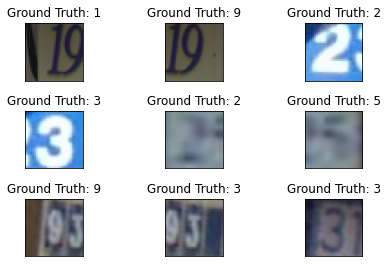

In [10]:
dataiter = enumerate(trainloader)
_, (train_sample_data, train_sample_targets) = next(dataiter)

show_samples(train_sample_data, train_sample_targets)

##### Test Samples

tensor shape: (1000, 3, 32, 32)


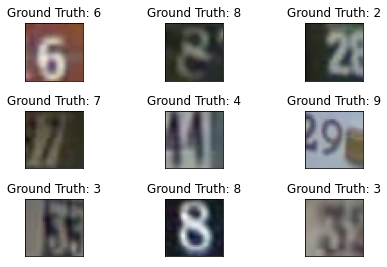

In [11]:
dataiter = enumerate(testloader)
_, (test_sample_data, test_sample_targets) = next(dataiter)

show_samples(test_sample_data, test_sample_targets)

##### Calibration Samples

tensor shape: (750, 3, 32, 32)


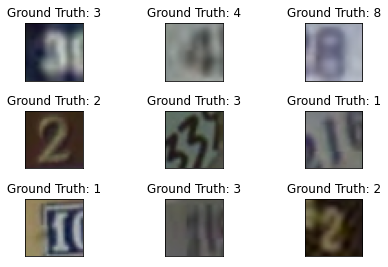

In [12]:
dataiter = enumerate(calibloader)
_, (calib_sample_data, calib_sample_targets) = next(dataiter)

show_samples(calib_sample_data, calib_sample_targets)

### Define Test Functions

In [13]:
def test(model, crit, data_loader, test_losses, test_accs):
    model.eval()
    correct = 0
    test_loss = 0
    
    with torch.no_grad():
        for data in data_loader:
            # Get the inputs; data is a list of [inputs, labels]
            inputs, targets = data

            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            
            # Forward + loss + correct
            outputs = model(inputs)
            test_loss += crit(outputs, targets).item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == targets).sum().item()
          
    dataset_size = len(data_loader.dataset)
    test_loss /= dataset_size
    acc = 100. * correct / dataset_size
    
    test_losses.append(test_loss)
    test_accs.append(acc)
    
    print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, dataset_size, acc
    ))
    
    return test_losses, test_accs

### Network Architecture

In [14]:
class SvhnNet(nn.Module):
    def __init__(self):
        super(SvhnNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=8, stride=2, padding=3)
        self.relu1 = nn.ReLU(True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=6, stride=2)
        self.relu2 = nn.ReLU(True)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=5)
        self.relu3 = nn.ReLU(True)
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = x.view(-1, 512)
        x = self.fc(x)
        return x

### Model Testing

In [15]:
# Create Model
model = SvhnNet()
criterion = nn.CrossEntropyLoss()

# Load Model
model.load_state_dict(
    torch.load("/Users/lehmann/research/laca/models/svhn_model.pth", map_location=torch.device('cpu'))
)

<All keys matched successfully>

In [16]:
model

SvhnNet(
  (conv1): Conv2d(3, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2))
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU(inplace=True)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [17]:
layers = {
    'relu1': model.relu1,
    'relu2': model.relu2,
    'relu3': model.relu3,
    'fc': model.fc
}

In [18]:
model.eval()

if use_cuda:
    model.cuda()
    print('Using ', torch.cuda.device_count(), ' GPU(s)')

In [19]:
def test_final(model, data_loader):
    _, accs = test(model, criterion, data_loader, [], [])
    return accs[0]

In [20]:
test_acc = test_final(model, testloader); test_acc


Test set: Avg. loss: 0.000375, Accuracy: 22739/25282 (89.94%)



89.94146032750574

## DkNN Initialization

In [21]:
def get_activations(dataloader, model, layers):
    activations = {}
    activations['activations'] = {}
    activations['targets'] = None

    for layer_name in layers:
        print('## Fetching Activations from Layer {}'.format(layer_name))

        # Get activations for the data
        layer = layers[layer_name]
        activations['activations'][layer_name], targets = get_activations_from_layer(dataloader, model, layer)

        # Get the targets of that data
        if targets is not None:
            if activations['targets'] is not None:
                np.testing.assert_array_equal(activations['targets'], targets)
            else:
                activations['targets'] = targets

        print()

    return activations

def get_activations_from_layer(dataloader, model, layer):
    activations = []
    targets = []

    # Define hook for fetching the activations
    def hook(module, input, output):
        layer_activations = output.squeeze().detach().cpu().numpy()

        if len(layer_activations.shape) == 4:
            layer_activations = layer_activations.reshape(layer_activations.shape[0], -1)
        
        activations.append(layer_activations)

    handle = layer.register_forward_hook(hook)

    # Fetch activations
    for i, batch in enumerate(dataloader):
        print('Processing Batch {}'.format(i))

        if use_cuda:
            batch = batch.cuda()

        _ = model(batch[0])

        if len(batch) > 1:
            targets.append(batch[1].detach().cpu().numpy())

    print("done!")

    # Remove hook
    handle.remove()

    # Return activations and targets
    activations = np.concatenate(activations)

    if targets:
        targets = np.hstack(targets)
    else:
        None

    return activations, targets


class NearestNeighbor:

    class BACKEND(enum.Enum):
        FALCONN = 1
        FAISS = 2

    def __init__(self, backend, dimension, neighbors, number_bits, nb_tables=None):
        assert backend in NearestNeighbor.BACKEND

        self._NEIGHBORS = neighbors
        self._BACKEND = backend

        if self._BACKEND is NearestNeighbor.BACKEND.FALCONN:
            self._init_falconn(dimension, number_bits, nb_tables)
        elif self._BACKEND is NearestNeighbor.BACKEND.FAISS:
            self._init_faiss(dimension)
        else:
            raise NotImplementedError

    def _init_falconn(self, dimension, number_bits, nb_tables):
        assert nb_tables >= self._NEIGHBORS

        # LSH parameters
        params_cp = falconn.LSHConstructionParameters()
        params_cp.dimension = dimension
        params_cp.lsh_family = falconn.LSHFamily.CrossPolytope
        params_cp.distance_function = falconn.DistanceFunction.EuclideanSquared
        params_cp.l = nb_tables
        params_cp.num_rotations = 2  # for dense set it to 1; for sparse data set it to 2
        params_cp.seed = 5721840
        params_cp.num_setup_threads = 0  # we want to use all the available threads to set up
        params_cp.storage_hash_table = falconn.StorageHashTable.BitPackedFlatHashTable

        # we build number_bits-bit hashes so that each table has
        # 2^number_bits bins; a rule of thumb is to have the number
        # of bins be the same order of magnitude as the number of data points
        falconn.compute_number_of_hash_functions(number_bits, params_cp)
        self._falconn_table = falconn.LSHIndex(params_cp)
        self._falconn_query_object = None
        self._FALCONN_NB_TABLES = nb_tables

    def _init_faiss(self, dimension):
        res = faiss.StandardGpuResources()
        self._faiss_index = faiss.GpuIndexFlatL2(res, dimension)

    def add(self, x):
        if self._BACKEND is NearestNeighbor.BACKEND.FALCONN:
            self._falconn_table.setup(x)
        elif self._BACKEND is NearestNeighbor.BACKEND.FAISS:
            self._faiss_index.add(x)
        else:
            raise NotImplementedError

    def find_knns(self, x, output):
        if self._BACKEND is NearestNeighbor.BACKEND.FALCONN:
            return self._find_knns_falconn(x, output)
        elif self._BACKEND is NearestNeighbor.BACKEND.FAISS:
            return self._find_knns_faiss(x, output)
        else:
            raise NotImplementedError

    def _find_knns_falconn(self, x, output):
        # Late falconn query_object construction
        # Since I suppose there might be an error
        # if table.setup() will be called after
        if self._falconn_query_object is None:
            self._falconn_query_object = self._falconn_table.construct_query_object()
            self._falconn_query_object.set_num_probes(self._FALCONN_NB_TABLES)

        missing_indices = np.zeros(output.shape, dtype=np.bool)

        for i in range(x.shape[0]):
            query_res = self._falconn_query_object.find_k_nearest_neighbors(x[i], self._NEIGHBORS)

            try:
                output[i, :] = query_res
            except:
                # mark missing indices
                missing_indices[i, len(query_res):] = True
                output[i, :len(query_res)] = query_res

        return missing_indices

    def _find_knns_faiss(self, x, output):
        neighbor_distance, neighbor_index = self._faiss_index.search(x, self._NEIGHBORS)

        missing_indices = neighbor_distance == -1
        d1 = neighbor_index.reshape(-1)

        output.reshape(-1)[np.logical_not(missing_indices.flatten())] = d1[np.logical_not(missing_indices.flatten())]

        return missing_indices


class DkNN:

    def __init__(self, model, nb_classes, neighbors, layers, trainloader, nearest_neighbor_backend, nb_tables=200, number_bits=17):
        """
        Implementation of the DkNN algorithm, see https://arxiv.org/abs/1803.04765 for more details
        :param model: model to be used
        :param nb_classes: the number of classes in the task
        :param neighbors: number of neighbors to find per layer
        :param layers: a list of layer names to include in the DkNN
        :param trainloader: data loader for the training data
        :param nearest_neighbor_backend: falconn or faiss to be used for LSH
        :param nb_tables: number of tables used by FALCONN to perform locality-sensitive hashing.
        :param number_bits: number of hash bits used by LSH.
        """
        print('---------- DkNN init')
        print()

        self.model = model
        self.nb_classes = nb_classes
        self.neighbors = neighbors
        self.layers = layers
        self.backend = nearest_neighbor_backend
        self.nb_tables = nb_tables
        self.number_bits = number_bits

        self.nb_cali = -1
        self.calibrated = False   

        # Compute training data activations
        activations = get_activations(trainloader, model, layers)
        self.train_activations = activations['activations']
        self.train_labels = activations['targets']

        # Build locality-sensitive hashing tables for training representations
        self.train_activations_lsh = copy.copy(self.train_activations)
        self.init_lsh()

    def init_lsh(self):
        """
        Initializes locality-sensitive hashing with FALCONN to find nearest neighbors in training data
        """
        self.query_objects = {} # contains the object that can be queried to find nearest neighbors at each layer
        self.centers = {} # mean of training data representation per layer (that needs to be substracted before NearestNeighbor)

        print("## Constructing the NearestNeighbor tables")

        for layer in self.layers:
            print("Constructing table for {}".format(layer))

            # Normalize all the lenghts, since we care about the cosine similarity
            self.train_activations_lsh[layer] /= np.linalg.norm(self.train_activations_lsh[layer], axis=1).reshape(-1, 1)

            # Center the dataset and the queries: this improves the performance of LSH quite a bit
            center = np.mean(self.train_activations_lsh[layer], axis=0)
            self.train_activations_lsh[layer] -= center
            self.centers[layer] = center

            # Constructing nearest neighbor table
            self.query_objects[layer] = NearestNeighbor(
                backend=self.backend,
                dimension=self.train_activations_lsh[layer].shape[1],
                number_bits=self.number_bits,
                neighbors=self.neighbors,
                nb_tables=self.nb_tables,
            )

            self.query_objects[layer].add(self.train_activations_lsh[layer])

        print("done!")
        print()


    def calibrate(self, calibloader):
        """
        Runs the DkNN on holdout data to calibrate the credibility metric
        :param calibloader: data loader for the calibration loader
        """
        print('---------- DkNN calibrate')
        print()

        # Compute calibration data activations
        self.nb_cali = len(calibloader.dataset)
        activations = get_activations(calibloader, self.model, self.layers)
        self.cali_activations = activations['activations']
        self.cali_labels = activations['targets']

        print("## Starting calibration of DkNN")

        cali_knns_ind, cali_knns_labels = self.find_train_knns(self.cali_activations)
        assert all([v.shape == (self.nb_cali, self.neighbors) for v in cali_knns_ind.values()])
        assert all([v.shape == (self.nb_cali, self.neighbors) for v in cali_knns_labels.values()])

        cali_knns_not_in_class = self.nonconformity(cali_knns_labels)
        cali_knns_not_in_l = np.zeros(self.nb_cali, dtype=np.int32)

        for i in range(self.nb_cali):
            cali_knns_not_in_l[i] = cali_knns_not_in_class[i, self.cali_labels[i]]

        cali_knns_not_in_l_sorted = np.sort(cali_knns_not_in_l)
        self.cali_nonconformity = np.trim_zeros(cali_knns_not_in_l_sorted, trim='f')
        self.nb_cali = self.cali_nonconformity.shape[0]
        self.calibrated = True

        print("DkNN calibration complete")

    def find_train_knns(self, data_activations):
        """
        Given a data_activation dictionary that contains a np array with activations for each layer,
        find the knns in the training data
        """
        knns_ind = {}
        knns_labels = {}

        for layer in self.layers:
            # Pre-process representations of data to normalize and remove training data mean
            data_activations_layer = copy.copy(data_activations[layer])
            nb_data = data_activations_layer.shape[0]
            data_activations_layer /= np.linalg.norm(data_activations_layer, axis=1).reshape(-1, 1)
            data_activations_layer -= self.centers[layer]

            # Use FALCONN to find indices of nearest neighbors in training data
            knns_ind[layer] = np.zeros((data_activations_layer.shape[0], self.neighbors), dtype=np.int32)
            knn_errors = 0

            knn_missing_indices = self.query_objects[layer].find_knns(data_activations_layer, knns_ind[layer])
            knn_errors += knn_missing_indices.flatten().sum()

            # Find labels of neighbors found in the training data
            knns_labels[layer] = np.zeros((nb_data, self.neighbors), dtype=np.int32)

            knns_labels[layer].reshape(-1)[
                np.logical_not(knn_missing_indices.flatten())
            ] = self.train_labels[
                knns_ind[layer].reshape(-1)[np.logical_not(knn_missing_indices.flatten())]                    
            ]

        return knns_ind, knns_labels

    def nonconformity(self, knns_labels):
        """
        Given an dictionary of nb_data x nb_classes dimension, compute the nonconformity of
        each candidate label for each data point: i.e. the number of knns whose label is
        different from the candidate label
        """
        nb_data = knns_labels[list(self.layers.keys())[0]].shape[0]
        knns_not_in_class = np.zeros((nb_data, self.nb_classes), dtype=np.int32)

        for i in range(nb_data):
            # Compute number of nearest neighbors per class
            knns_in_class = np.zeros((len(self.layers), self.nb_classes), dtype=np.int32)

            for layer_id, layer in enumerate(self.layers):
                knns_in_class[layer_id, :] = np.bincount(knns_labels[layer][i], minlength=self.nb_classes)

            # Compute number of knns in other class than class_id
            for class_id in range(self.nb_classes):
                knns_not_in_class[i, class_id] = np.sum(knns_in_class) - np.sum(knns_in_class[:, class_id])

        return knns_not_in_class

    def fprop(self, testloader):
        """
        Performs a forward pass through the DkNN on an numpy array of data
        """
        print('---------- DkNN predict')
        print()

        if not self.calibrated:
            raise ValueError("DkNN needs to be calibrated by calling DkNNModel.calibrate method once before inferring")

        # Compute test data activations
        activations = get_activations(testloader, self.model, self.layers)
        data_activations = activations['activations']
        
        start_time = time.time()
        _, knns_labels = self.find_train_knns(data_activations)
        end_time = time.time()
        
        print('kNN search time: {}'.format(end_time - start_time))

        # Calculate nonconformity
        knns_not_in_class = self.nonconformity(knns_labels)
        print('Nonconformity calculated')

        # Create predictions, confidence and credibility
        _, _, creds = self.preds_conf_cred(knns_not_in_class)
        print('Predictions created')

        return creds, activations['targets']

    def preds_conf_cred(self, knns_not_in_class):
        """
        Given an array of nb_data x nb_classes dimensions, use conformal prediction to compute
        the DkNN's prediction, confidence and credibility
        """
        nb_data = knns_not_in_class.shape[0]
        preds_knn = np.zeros(nb_data, dtype=np.int32)
        confs = np.zeros((nb_data, self.nb_classes), dtype=np.float32)
        creds = np.zeros((nb_data, self.nb_classes), dtype=np.float32)

        for i in range(nb_data):
            # p-value of test input for each class
            p_value = np.zeros(self.nb_classes, dtype=np.float32)

            for class_id in range(self.nb_classes):
                # p-value of (test point, candidate label)
                p_value[class_id] = (float(self.nb_cali) - bisect_left(self.cali_nonconformity, knns_not_in_class[i, class_id])) / float(self.nb_cali)

            preds_knn[i] = np.argmax(p_value)
            confs[i, preds_knn[i]] = 1. - np.sort(p_value)[-2]
            creds[i, preds_knn[i]] = p_value[preds_knn[i]]

        return preds_knn, confs, creds


def plot_reliability_diagram(confidence, labels):
    """
    Takes in confidence values (e.g. output of softmax or DkNN confidences) for
    predictions and correct labels for the data, plots a reliability diagram
    :param confidence: nb_samples x nb_classes with confidence scores
    :param labels: targets
    """
    assert len(confidence.shape) == 2
    assert len(labels.shape) == 1
    assert confidence.shape[0] == labels.shape[0]

    if confidence.max() <= 1.:
        # confidence array is output of softmax
        bins_start = [b / 10. for b in range(0, 10)]
        bins_end = [b / 10. for b in range(1, 11)]
        bins_center = [(b + .5) / 10. for b in range(0, 10)]
        preds_conf = np.max(confidence, axis=1)
        preds_l = np.argmax(confidence, axis=1)
    else:
        raise ValueError('Confidence values go above 1')

    print(preds_conf.shape, preds_l.shape)

    # Create var for reliability diagram (Will contain mean accuracies for each bin)
    reliability_diag = []
    num_points = []  # keeps the number of points in each bar

    # Find average accuracy per confidence bin
    for bin_start, bin_end in zip(bins_start, bins_end):
        above = preds_conf >= bin_start

        if bin_end == 1.:
            below = preds_conf <= bin_end
        else:
            below = preds_conf < bin_end

        mask = np.multiply(above, below)
        num_points.append(np.sum(mask))

        bin_mean_acc = max(0, np.mean(preds_l[mask] == labels[mask]))
        reliability_diag.append(bin_mean_acc)

    # Plot diagram
    assert len(reliability_diag) == len(bins_center)
    #print(reliability_diag)
    #print(bins_center)
    #print(num_points)

    fig, ax1 = plt.subplots()
    _ = ax1.bar(bins_center, reliability_diag, width=.1, alpha=0.8, edgecolor = "black")
    plt.xlim([0, 1.])
    ax1.set_ylim([0, 1.])

    ax2 = ax1.twinx()

    #print(sum(num_points))

    ax2.plot(bins_center, num_points, color='r', linestyle='-', linewidth=7.0)
    ax2.set_ylabel('Number of points in the data', fontsize=16, color='r')

    if len(np.argwhere(confidence[0] != 0.)) == 1:
        # This is a DkNN diagram
        ax1.set_xlabel('Prediction Credibility', fontsize=16)
    else:
        # This is a softmax diagram
        ax1.set_xlabel('Prediction Confidence', fontsize=16)

    ax1.set_ylabel('Prediction Accuracy', fontsize=16)
    ax1.tick_params(axis='both', labelsize=14)
    ax2.tick_params(axis='both', labelsize=14, colors='r')
    fig.tight_layout()
    plt.show()

In [22]:
# Initialize DkNN
dknn = DkNN(model, num_classes, neighbors, layers, trainloader_dknn, NearestNeighbor.BACKEND.FALCONN)

---------- DkNN init

## Fetching Activations from Layer relu1
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
Processing Batch 10
Processing Batch 11
Processing Batch 12
Processing Batch 13
Processing Batch 14
Processing Batch 15
Processing Batch 16
Processing Batch 17
Processing Batch 18
Processing Batch 19
Processing Batch 20
Processing Batch 21
Processing Batch 22
Processing Batch 23
Processing Batch 24
Processing Batch 25
Processing Batch 26
Processing Batch 27
Processing Batch 28
Processing Batch 29
Processing Batch 30
Processing Batch 31
Processing Batch 32
Processing Batch 33
Processing Batch 34
Processing Batch 35
Processing Batch 36
Processing Batch 37
Processing Batch 38
Processing Batch 39
Processing Batch 40
Processing Batch 41
Processing Batch 42
Processing Batch 43
Processing Batch 44
Processing Batch 45
Processing Batch 46
Process

Processing Batch 105
Processing Batch 106
Processing Batch 107
Processing Batch 108
Processing Batch 109
Processing Batch 110
Processing Batch 111
Processing Batch 112
Processing Batch 113
Processing Batch 114
Processing Batch 115
Processing Batch 116
Processing Batch 117
Processing Batch 118
Processing Batch 119
Processing Batch 120
Processing Batch 121
Processing Batch 122
Processing Batch 123
Processing Batch 124
Processing Batch 125
Processing Batch 126
Processing Batch 127
Processing Batch 128
Processing Batch 129
Processing Batch 130
Processing Batch 131
Processing Batch 132
Processing Batch 133
Processing Batch 134
Processing Batch 135
Processing Batch 136
Processing Batch 137
Processing Batch 138
Processing Batch 139
Processing Batch 140
Processing Batch 141
Processing Batch 142
Processing Batch 143
Processing Batch 144
Processing Batch 145
Processing Batch 146
done!

## Fetching Activations from Layer fc
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch

In [23]:
dknn.calibrate(calibloader)

---------- DkNN calibrate

## Fetching Activations from Layer relu1
Processing Batch 0
done!

## Fetching Activations from Layer relu2
Processing Batch 0
done!

## Fetching Activations from Layer relu3
Processing Batch 0
done!

## Fetching Activations from Layer fc
Processing Batch 0
done!

## Starting calibration of DkNN
DkNN calibration complete


## Get Testset Credibility

In [24]:
start_credib = time.time()

dknn_preds_testset, test_targets = dknn.fprop(testloader)

end_credib = time.time()

---------- DkNN predict

## Fetching Activations from Layer relu1
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
Processing Batch 10
Processing Batch 11
Processing Batch 12
Processing Batch 13
Processing Batch 14
Processing Batch 15
Processing Batch 16
Processing Batch 17
Processing Batch 18
Processing Batch 19
Processing Batch 20
Processing Batch 21
Processing Batch 22
Processing Batch 23
Processing Batch 24
Processing Batch 25
done!

## Fetching Activations from Layer relu2
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
Processing Batch 10
Processing Batch 11
Processing Batch 12
Processing Batch 13
Processing Batch 14
Processing Batch 15
Processing Batch 16
Processing Batch 17
Processing Batch 18
Proces

In [25]:
print('---------------------------------------------')
print('preds:   {}'.format(dknn_preds_testset.shape))
print('targets: {}'.format(test_targets.shape))

---------------------------------------------
preds:   (25282, 10)
targets: (25282,)


In [26]:
test_credibs = list(np.max(dknn_preds_testset, axis=1))

In [27]:
num_samples = len(test_credibs)
total_credib = np.sum(np.array(test_credibs)) / num_samples
print(total_credib)

0.5011371340652441


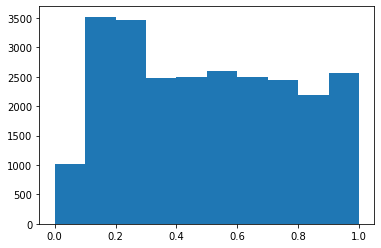

In [28]:
plt.hist(test_credibs, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]);

(25282,) (25282,)


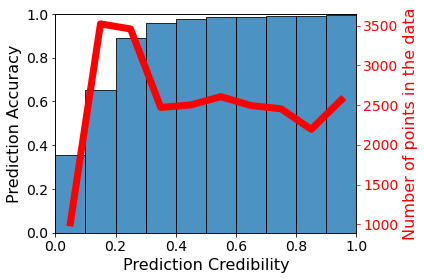

In [29]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    plot_reliability_diagram(dknn_preds_testset, test_targets)

## Time Measurement

In [30]:
time_total = end_credib - start_credib
print('total: {}'.format(time_total))

total: 1137.6986927986145
